In [6]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import random
%matplotlib inline
%config InlineBackend.figure_format='retina'
np.set_printoptions(suppress=True)

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": "Helvetica",
})

NUM_BITS = 10600
AVG_EMD_BASELINE_EoL = 1.346362954366226

In [7]:
def get_wi(i_bi, i_bw):
    return int(i_bi/i_bw)

def get_wbi(i_bi, i_bw):
    return int(i_bi%i_bw)

def get_wi_wbi(i_bi, i_bw):
    return get_wi(i_bi, i_bw), get_wbi(i_bi, i_bw)

def parse_ranking_file(file):
    """
    Parse the ranking file which contains a list of (bit index, ranking val) 
    into a list of bit indices and a list of ranking values
    """
    bit_indices = []
    vals = []
    with open(file, 'r') as f:
        for i, line in enumerate(f):
            if i == 0:
                # Skip the header
                continue
            line = line.strip()
            if line:
                bit_idx, val = line.split(',')
                bit_indices.append(int(bit_idx))
                vals.append(float(val))
    return bit_indices, vals

In [8]:
ground_truth_rank, ground_truth_emd = parse_ranking_file('encoder_param_ranking_ground_truth.txt')

In [9]:
len(ground_truth_emd)

10600

In [10]:
# Get top 1% highest ranking bits
top_1pct = int(len(ground_truth_rank) * 0.01)
top_1pct_bit_indices = ground_truth_rank[:top_1pct]
top_1pct_emd = ground_truth_emd[:top_1pct]
# Get top 3% highest ranking bits
top_3pct = int(len(ground_truth_rank) * 0.03)
top_3pct_bit_indices = ground_truth_rank[:top_3pct]
top_3pct_emd = ground_truth_emd[:top_3pct]
# Get top 10% highest ranking bits
top_10pct = int(len(ground_truth_rank) * 0.1)
top_10pct_bit_indices = ground_truth_rank[:top_10pct]
top_10pct_emd = ground_truth_emd[:top_10pct]
# Get top 30% highest ranking bits
top_30pct = int(len(ground_truth_rank) * 0.3)
top_30pct_bit_indices = ground_truth_rank[:top_30pct]
top_30pct_emd = ground_truth_emd[:top_30pct]

In [11]:
top_10pct_bit_indices[:15]

[5, 240, 5825, 165, 45, 250, 6, 8145, 2370, 80, 166, 35, 8160, 4325, 125]

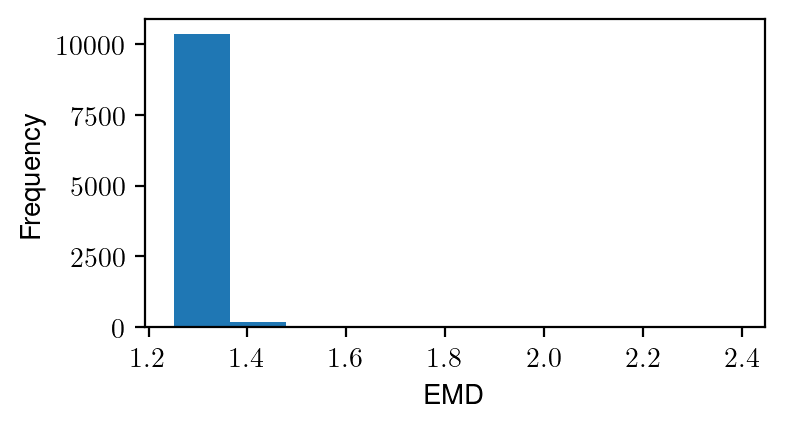

In [12]:
# Plot histogram of the EMD values
fig, ax = plt.subplots(figsize=(4,2)) # Sample figsize in inches
ax.hist(ground_truth_emd)
ax.set_xlabel('EMD')
ax.set_ylabel('Frequency')
plt.savefig('plots/histogram_faulty_emd.pdf', dpi=300, bbox_inches='tight')

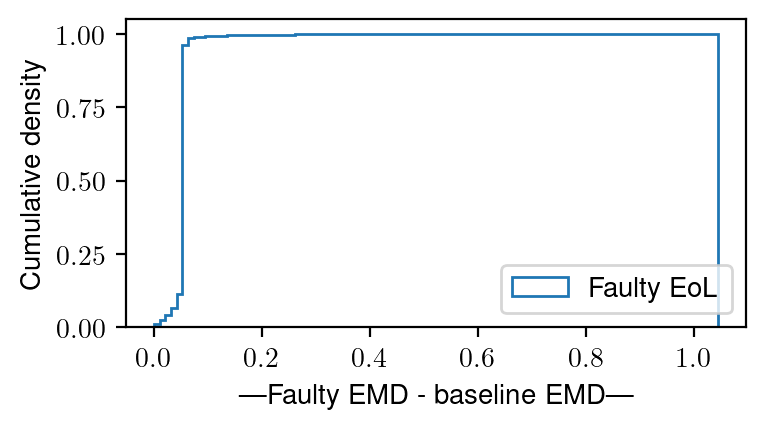

In [13]:
# Plot histogram of the delta EMD values from the baseline
fig, ax = plt.subplots(figsize=(4,2)) # Sample figsize in inches
ax.hist(np.absolute(np.array(ground_truth_emd) - AVG_EMD_BASELINE_EoL), cumulative=True, density=True, bins=100, histtype='step', label='Faulty EoL')
ax.set_xlabel('|Faulty EMD - baseline EMD|')
ax.set_ylabel('Cumulative density')
ax.legend(loc='lower right')
plt.savefig('plots/histogram_faulty_delta_emd.pdf', dpi=300, bbox_inches='tight')

In [21]:
# Convert encoder Hessian parameter ranking to bit indices 
BITWIDTH = 5
def sort_bits_MSB_to_LSB(param_bit_order_ranking):
    """
    Given a bit ranking in which the bits are ordered from MSB to LSB in
    parameter order, return a list of bit indices where all the MSBs are first,
    followed by all the MSBs - 1, etc.
    """
    # Sort from MSB to LSB
    # sign_bits = param_bit_order_ranking[0::BITWIDTH]
    # int_bits = param_bit_order_ranking[1::BITWIDTH]
    # frac_bits = np.concatenate((
    #     param_bit_order_ranking[2::BITWIDTH], 
    #     param_bit_order_ranking[3::BITWIDTH], 
    #     param_bit_order_ranking[4::BITWIDTH]
    # ))
    # bit_rank = np.concatenate((sign_bits, int_bits, frac_bits))
    bit_rank = [] 
    for i in range(BITWIDTH): 
        bit_group = param_bit_order_ranking[i::BITWIDTH]
        bit_rank.extend(bit_group)
        
        
    return np.array(bit_rank)

def convert_param_ranking_to_bit_ranking(param_ranking, param_score):
    # Convert param ranking to bit ranking
    bit_level_rank = []
    for i, param in enumerate(param_ranking):
        bit_idx = param * BITWIDTH
        bit_level_rank.append(bit_idx)
        for j in range(1, BITWIDTH):
            bit_level_rank.append(bit_idx + j)
    # Sort from MSB to LSB
    bit_level_rank = sort_bits_MSB_to_LSB(bit_level_rank)
    return bit_level_rank

def layer_convert_param_ranking_to_bit_ranking(conv_param_ranking, conv_param_score, dense_param_ranking, dense_param_score, threshold=0.01):
    # Conv param ranking
    num_conv_bits = len(conv_param_ranking) * BITWIDTH
    bit_level_rank_conv = []
    remaining_conv_bits = []
    for i, param in enumerate(conv_param_ranking):
        bit_idx = param * BITWIDTH
        if conv_param_score[i] > threshold:
            bit_level_rank_conv.append(bit_idx)
            for j in range(1, BITWIDTH):
                bit_level_rank_conv.append(bit_idx + j)
        else:
            remaining_conv_bits.append(bit_idx)
            for j in range(1, BITWIDTH):
                remaining_conv_bits.append(bit_idx + j)
    # Sort from MSB to LSB
    conv_bit_rank = sort_bits_MSB_to_LSB(bit_level_rank_conv)
    remaining_conv_bits = sort_bits_MSB_to_LSB(remaining_conv_bits)
    # Dense param ranking
    bit_level_rank_dense = []
    remaining_dense_bits = []
    for i, param in enumerate(dense_param_ranking):
        bit_idx = param * BITWIDTH + num_conv_bits
        if dense_param_score[i] > threshold:
            bit_level_rank_dense.append(bit_idx)
            for j in range(1, BITWIDTH):
                bit_level_rank_dense.append(bit_idx + j)
        else:
            remaining_dense_bits.append(bit_idx)
            for j in range(1, BITWIDTH):
                remaining_dense_bits.append(bit_idx + j)
    # Sort from MSB to LSB
    dense_bit_rank = sort_bits_MSB_to_LSB(bit_level_rank_dense)
    remaining_dense_bits = sort_bits_MSB_to_LSB(remaining_dense_bits)
    # Concatenate conv and dense bit ranking
    bit_ranking = np.concatenate((conv_bit_rank, dense_bit_rank, remaining_conv_bits, remaining_dense_bits))
    return bit_ranking

In [22]:
# Parse hessian ranking file
conv_hess_rank, conv_hess_score = parse_ranking_file('sensitivity_ranking_layer_conv2d_0_m.txt')
dense_hess_rank, dense_hess_score = parse_ranking_file('sensitivity_ranking_layer_encoded_vector.txt')
hessian_rank = layer_convert_param_ranking_to_bit_ranking(conv_hess_rank, conv_hess_score,dense_hess_rank, dense_hess_score, threshold=0.05)
# Parse (top 3) hessian ranking file
conv_hess_rank_top3, conv_hess_score_top3 = parse_ranking_file('top3_hess_ranking_layer_conv2d_0_m.txt')
dense_hess_rank_top3, dense_hess_score_top3 = parse_ranking_file('top3_hess_ranking_layer_encoded_vector.txt')
hessian_rank_top3 = layer_convert_param_ranking_to_bit_ranking(
    conv_hess_rank_top3, 
    conv_hess_score_top3, 
    dense_hess_rank_top3, 
    dense_hess_score_top3,
    threshold=0.05
)
# Parse (top 5) hessian ranking file
conv_hess_rank_top5, conv_hess_score_top5 = parse_ranking_file('top5_hess_ranking_layer_conv2d_0_m.txt')
dense_hess_rank_top5, dense_hess_score_top5 = parse_ranking_file('top5_hess_ranking_layer_encoded_vector.txt')
hessian_rank_top5 = layer_convert_param_ranking_to_bit_ranking(
    conv_hess_rank_top5, 
    conv_hess_score_top5, 
    dense_hess_rank_top5, 
    dense_hess_score_top5,
    threshold=0.05
)
# Parse (top 8) hessian ranking file
conv_hess_rank_top8, conv_hess_score_top8 = parse_ranking_file('top8_hess_ranking_layer_conv2d_0_m.txt')
dense_hess_rank_top8, dense_hess_score_top8 = parse_ranking_file('top8_hess_ranking_layer_encoded_vector.txt')
hessian_rank_top8 = layer_convert_param_ranking_to_bit_ranking(
    conv_hess_rank_top8, 
    conv_hess_score_top8, 
    dense_hess_rank_top8, 
    dense_hess_score_top8,
    threshold=0.05
)
# Parse (top 8) hessian ranking (eigenvalue included in score) file
conv_hess_eigenval_rank_top8, conv_hess_eigenval_score_top8 = parse_ranking_file('top8_hess_eigenval_ranking_layer_conv2d_0_m.txt')
dense_hess_eigenval_rank_top8, dense_hess_eigenval_score_top8 = parse_ranking_file('top8_hess_eigenval_ranking_layer_encoded_vector.txt')
hessian_eigenval_rank_top8 = layer_convert_param_ranking_to_bit_ranking(
    conv_hess_eigenval_rank_top8, 
    conv_hess_eigenval_score_top8, 
    dense_hess_eigenval_rank_top8, 
    dense_hess_eigenval_score_top8,
    threshold=0.8
)
# Parse gradient ranking file
conv_grad_rank, conv_grad_score = parse_ranking_file('gradient_ranking_layer_conv2d_0_m.txt')
dense_grad_rank, dense_grad_score = parse_ranking_file('gradient_ranking_layer_encoded_vector.txt')
gradient_rank = layer_convert_param_ranking_to_bit_ranking(conv_grad_rank, conv_grad_score, dense_grad_rank, dense_grad_score, threshold=0.05)

# Parse (top 1) model-wide hessian ranking (eigenvalue included in score) file
model_hess_eigenval_rank_top1, model_hess_eigenval_score_top1 = parse_ranking_file('top1_hess_eigenval_ranking.txt')
model_hessian_eigenval_rank_top1 = convert_param_ranking_to_bit_ranking(
    model_hess_eigenval_rank_top1, model_hess_eigenval_score_top1
)

# Parse (top 8) model-wide hessian ranking (eigenvalue included in score) file
model_hess_eigenval_rank_top8, model_hess_eigenval_score_top8 = parse_ranking_file('top8_hess_eigenval_ranking.txt')
model_hessian_eigenval_rank_top8 = convert_param_ranking_to_bit_ranking(
    model_hess_eigenval_rank_top8, model_hess_eigenval_score_top8
)

# Parse (top 24) model-wide hessian ranking (eigenvalue included in score) file
model_hess_eigenval_rank_top24, model_hess_eigenval_score_top24 = parse_ranking_file('top24_hess_eigenval_ranking.txt')
model_hessian_eigenval_rank_top24 = convert_param_ranking_to_bit_ranking(
    model_hess_eigenval_rank_top24, model_hess_eigenval_score_top24
)

# Parse (top 50) model-wide hessian ranking (eigenvalue included in score) file
model_hess_eigenval_rank_top50, model_hess_eigenval_score_top50 = parse_ranking_file('top50_hess_eigenval_ranking.txt')
model_hessian_eigenval_rank_top50 = convert_param_ranking_to_bit_ranking(
    model_hess_eigenval_rank_top50, model_hess_eigenval_score_top50
)

# Parse (top 1) model-wide max hessian ranking file
model_max_hess_rank_top1, model_max_hess_score_top1 = parse_ranking_file('top1_hess_max_ranking.txt')
model_max_hessian_rank_top1 = convert_param_ranking_to_bit_ranking(
    model_max_hess_rank_top1, model_max_hess_score_top1
)

# Parse (top 5) model-wide max hessian ranking (eigenvalue included) file
model_max_hess_eigenval_rank_top5, model_max_hess_eigenval_score_top5 = parse_ranking_file('top5_hess_max_eigenval_ranking.txt')
model_max_hessian_eigenval_rank_top5 = convert_param_ranking_to_bit_ranking(
    model_max_hess_eigenval_rank_top5, model_max_hess_eigenval_score_top5
)

# Parse (top 8) model-wide max hessian ranking file
model_max_hess_rank_top8, model_max_hess_score_top8 = parse_ranking_file('top8_hess_max_ranking.txt')
model_max_hessian_rank_top8 = convert_param_ranking_to_bit_ranking(
    model_max_hess_rank_top8, model_max_hess_score_top8
)
# Parse (top 8) model-wide max hessian ranking (eigenvalue included) file
model_max_hess_eigenval_rank_top8, model_max_hess_eigenval_score_top8 = parse_ranking_file('top8_hess_max_eigenval_ranking.txt')
model_max_hessian_eigenval_rank_top8 = convert_param_ranking_to_bit_ranking(
    model_max_hess_eigenval_rank_top8, model_max_hess_eigenval_score_top8
)
# Parse (top 50) model-wide max hessian ranking (eigenvalue included) file
model_max_hess_eigenval_rank_top50, model_max_hess_eigenval_score_top50 = parse_ranking_file('top50_hess_max_eigenval_ranking.txt')
model_max_hessian_eigenval_rank_top50 = convert_param_ranking_to_bit_ranking(
    model_max_hess_eigenval_rank_top50, model_max_hess_eigenval_score_top50
)

# Parse (top 8) model-wise sum hessian bitwise ranking (eigenvalue included) file
model_sum_hess_eigenval_bitwise_rank_top8, model_sum_hess_eigenval_bitwise_score_top8 = parse_ranking_file('top8_hess_sum_eigenval_bit_ranking.txt')


print(f"Hessian rank: {hessian_rank[:15]}")
# print(f"Hessian top 3 rank: {hessian_rank_top3[:15]}")
# print(f"Hessian top 5 rank: {hessian_rank_top5[:15]}")
# print(f"Hessian top 8 rank: {hessian_rank_top8[:15]}")
print(f"Hessian top 8 eigenval rank: {hessian_eigenval_rank_top8[:15]}")
print(f"Gradient rank: {gradient_rank[:15]}")
# print(f"Model-wide Hessian top 1 eigenval rank: {model_hessian_eigenval_rank_top1[:15]}")
# print(f"Model-wide Hessian top 8 eigenval rank: {model_hessian_eigenval_rank_top8[:15]}")
# print(f"Model-wide Hessian top 24 eigenval rank: {model_hessian_eigenval_rank_top24[:15]}")
print(f"Model-wide Hessian top 50 eigenval rank: {model_hessian_eigenval_rank_top50[:15]}")


Hessian rank: [ 20   5 100 260 340  60  55  15 140 300 110   0 125 220  45]
Hessian top 8 eigenval rank: [ 20   5 100 260 340  60  55 140  15 300 110  45 125   0 220]
Gradient rank: [ 65  55  60 340 165   0 100 170  10 325  45 110 300 245 210]
Model-wide Hessian top 50 eigenval rank: [  20    5  100  260  340 3710   60 3630 4310  140   10 3705   45 4340
  170]


Found all bits with random at 10405 bits flipped
Found all bits with deterministic at 8806 bits flipped
Found all bits with bit ordered at 5357 bits flipped
Found all bits with Hessian at 4787 bits flipped
Found all bits with gradient at 4710 bits flipped
Found all bits with Hessian top 3 at 4802 bits flipped
Found all bits with Hessian top 5 at 3715 bits flipped
Found all bits with Hessian top 8 at 3953 bits flipped
Found all bits with Hessian eigenval top 8 at 4685 bits flipped
Found all bits with model Hessian eigenval top 1 at 4493 bits flipped
Found all bits with model Hessian eigenval top 8 at 4455 bits flipped
Found all bits with model Hessian eigenval top 24 at 4422 bits flipped
Found all bits with model Hessian eigenval top 50 at 4433 bits flipped
Found all bits with model max Hessian top 1 at 4677 bits flipped
Found all bits with model max Hessian top 8 at 4603 bits flipped
Found all bits with model max Hessian eigenval top 5 at 4593 bits flipped
Found all bits with model max

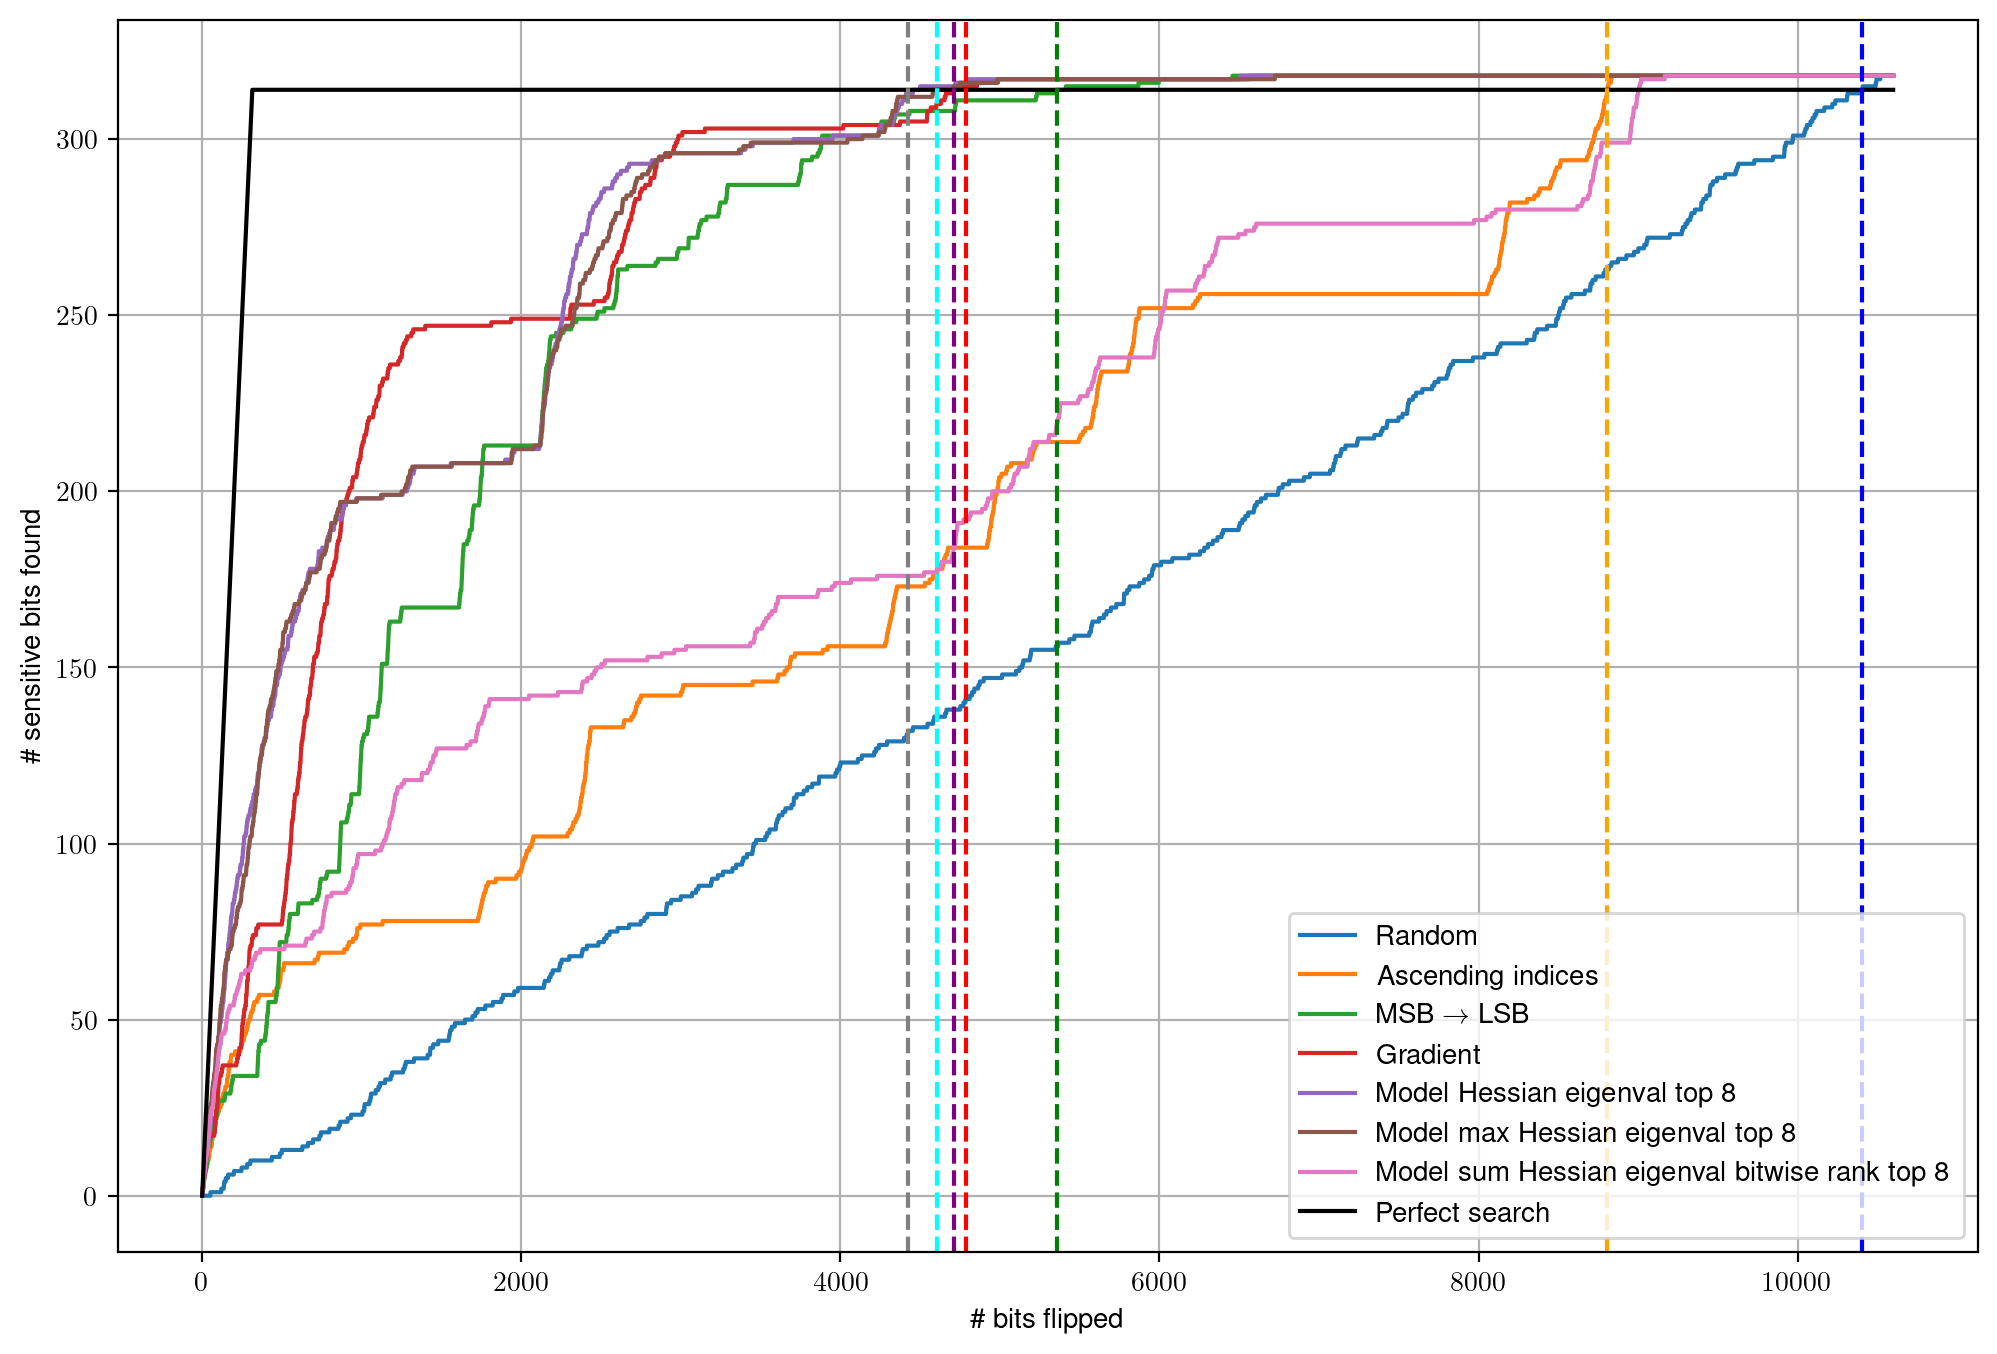

In [23]:
# Generate random list of bit indices to simulate random fault injection
random.seed(7654)
random_bit_indices = random.sample(range(NUM_BITS), NUM_BITS)
deterministic_bit_indices = np.arange(NUM_BITS)
# Search all sign bits first, then integer bits, then fractional bits
bit_ordered_indices = []
sign_bits = deterministic_bit_indices[0::5]
int_bits = deterministic_bit_indices[1::5]
frac_bits = np.concatenate((deterministic_bit_indices[2::5], deterministic_bit_indices[3::5], deterministic_bit_indices[4::5]))
bit_ordered_indices = np.concatenate((sign_bits, int_bits, frac_bits))

TOP_K_LABEL = 'top_3pct'
top_k_bit_indices = top_3pct_bit_indices
NUM_TOP_K_BIT_INDICES = int(len(top_k_bit_indices) * 0.99)

grad_found = []
random_found = []
hessian_found = []
hessian_top3_found = []
hessian_top5_found = []
hessian_top8_found = []
bit_ordered_found = []
deterministic_found = []
hessian_eigenval_top8_found = []
model_hessian_eigenval_top1_found = []
model_hessian_eigenval_top8_found = []
model_hessian_eigenval_top24_found = []
model_hessian_eigenval_top50_found = []
model_max_hessian_top1_found = []
model_max_hessian_top8_found = []
model_max_hessian_eigenval_top5_found = []
model_max_hessian_eigenval_top8_found = []
model_max_hessian_eigenval_top50_found = []
model_sum_hess_eigenval_bitwise_rank_top8_found = []
for i in range(NUM_BITS):
    if random_bit_indices[i] in top_k_bit_indices:
        random_found.append(1)
    if random_bit_indices[i] not in top_k_bit_indices:
        random_found.append(0)
    if deterministic_bit_indices[i] in top_k_bit_indices:
        deterministic_found.append(1)
    if deterministic_bit_indices[i] not in top_k_bit_indices:
        deterministic_found.append(0)
    if bit_ordered_indices[i] in top_k_bit_indices:
        bit_ordered_found.append(1)
    if bit_ordered_indices[i] not in top_k_bit_indices:
        bit_ordered_found.append(0)
    if hessian_rank[i] in top_k_bit_indices:
        hessian_found.append(1)
    if hessian_rank[i] not in top_k_bit_indices:
        hessian_found.append(0)
    if gradient_rank[i] in top_k_bit_indices:
        grad_found.append(1)
    if gradient_rank[i] not in top_k_bit_indices:
        grad_found.append(0)
    if hessian_rank_top3[i] in top_k_bit_indices:
        hessian_top3_found.append(1)
    if hessian_rank_top3[i] not in top_k_bit_indices:
        hessian_top3_found.append(0)
    if hessian_rank_top5[i] in top_k_bit_indices:
        hessian_top5_found.append(1)
    if hessian_rank_top5[i] not in top_k_bit_indices:
        hessian_top5_found.append(0)
    if hessian_rank_top8[i] in top_k_bit_indices:
        hessian_top8_found.append(1)
    if hessian_rank_top8[i] not in top_k_bit_indices:
        hessian_top8_found.append(0)
    if hessian_eigenval_rank_top8[i] in top_k_bit_indices:
        hessian_eigenval_top8_found.append(1)
    if hessian_eigenval_rank_top8[i] not in top_k_bit_indices:
        hessian_eigenval_top8_found.append(0)
    if model_hessian_eigenval_rank_top1[i] in top_k_bit_indices:
        model_hessian_eigenval_top1_found.append(1)
    if model_hessian_eigenval_rank_top1[i] not in top_k_bit_indices:
        model_hessian_eigenval_top1_found.append(0)
    if model_hessian_eigenval_rank_top8[i] in top_k_bit_indices:
        model_hessian_eigenval_top8_found.append(1)
    if model_hessian_eigenval_rank_top8[i] not in top_k_bit_indices:
        model_hessian_eigenval_top8_found.append(0)
    if model_hessian_eigenval_rank_top24[i] in top_k_bit_indices:
        model_hessian_eigenval_top24_found.append(1)
    if model_hessian_eigenval_rank_top24[i] not in top_k_bit_indices:
        model_hessian_eigenval_top24_found.append(0)
    if model_hessian_eigenval_rank_top50[i] in top_k_bit_indices:
        model_hessian_eigenval_top50_found.append(1)
    if model_hessian_eigenval_rank_top50[i] not in top_k_bit_indices:
        model_hessian_eigenval_top50_found.append(0)
    if model_max_hessian_rank_top1[i] in top_k_bit_indices:
        model_max_hessian_top1_found.append(1)
    if model_max_hessian_rank_top1[i] not in top_k_bit_indices:
        model_max_hessian_top1_found.append(0)
    if model_max_hessian_rank_top8[i] in top_k_bit_indices:
        model_max_hessian_top8_found.append(1)
    if model_max_hessian_rank_top8[i] not in top_k_bit_indices:
        model_max_hessian_top8_found.append(0)
    if model_max_hessian_eigenval_rank_top5[i] in top_k_bit_indices:
        model_max_hessian_eigenval_top5_found.append(1)
    if model_max_hessian_eigenval_rank_top5[i] not in top_k_bit_indices:
        model_max_hessian_eigenval_top5_found.append(0)
    if model_max_hessian_eigenval_rank_top8[i] in top_k_bit_indices:
        model_max_hessian_eigenval_top8_found.append(1)
    if model_max_hessian_eigenval_rank_top8[i] not in top_k_bit_indices:
        model_max_hessian_eigenval_top8_found.append(0)
    if model_max_hessian_eigenval_rank_top50[i] in top_k_bit_indices:
        model_max_hessian_eigenval_top50_found.append(1)
    if model_max_hessian_eigenval_rank_top50[i] not in top_k_bit_indices:
        model_max_hessian_eigenval_top50_found.append(0)
    if model_sum_hess_eigenval_bitwise_rank_top8[i] in top_k_bit_indices:
        model_sum_hess_eigenval_bitwise_rank_top8_found.append(1)
    if model_sum_hess_eigenval_bitwise_rank_top8[i] not in top_k_bit_indices:
        model_sum_hess_eigenval_bitwise_rank_top8_found.append(0)

random_found = np.cumsum(np.array(random_found))
random_all_bits_found = np.argwhere(random_found == NUM_TOP_K_BIT_INDICES)[0][0]
print(f"Found all bits with random at {random_all_bits_found} bits flipped")
deterministic_found = np.cumsum(np.array(deterministic_found))
deterministic_all_bits_found = np.argwhere(deterministic_found == NUM_TOP_K_BIT_INDICES)[0][0]
print(f"Found all bits with deterministic at {deterministic_all_bits_found} bits flipped")
bit_ordered_found = np.cumsum(np.array(bit_ordered_found))
bit_ordered_all_bits_found = np.argwhere(bit_ordered_found == NUM_TOP_K_BIT_INDICES)[0][0]
print(f"Found all bits with bit ordered at {bit_ordered_all_bits_found} bits flipped")
hessian_found = np.cumsum(np.array(hessian_found))
hess_all_bits_found = np.argwhere(hessian_found == NUM_TOP_K_BIT_INDICES)[0][0]
print(f"Found all bits with Hessian at {hess_all_bits_found} bits flipped")
grad_found = np.cumsum(np.array(grad_found))
grad_all_bits_found = np.argwhere(grad_found == NUM_TOP_K_BIT_INDICES)[0][0]
print(f"Found all bits with gradient at {grad_all_bits_found} bits flipped")
hessian_top3_found = np.cumsum(np.array(hessian_top3_found))
hess_top3_all_bits_found = np.argwhere(hessian_top3_found == NUM_TOP_K_BIT_INDICES)[0][0]
print(f"Found all bits with Hessian top 3 at {hess_top3_all_bits_found} bits flipped")
hessian_top5_found = np.cumsum(np.array(hessian_top5_found))
hess_top5_all_bits_found = np.argwhere(hessian_top5_found == NUM_TOP_K_BIT_INDICES)[0][0]
print(f"Found all bits with Hessian top 5 at {hess_top5_all_bits_found} bits flipped")
hessian_top8_found = np.cumsum(np.array(hessian_top8_found))
hess_top8_all_bits_found = np.argwhere(hessian_top8_found == NUM_TOP_K_BIT_INDICES)[0][0]
print(f"Found all bits with Hessian top 8 at {hess_top8_all_bits_found} bits flipped")
hessian_eigenval_top8_found = np.cumsum(np.array(hessian_eigenval_top8_found))
hess_eigenval_top8_all_bits_found = np.argwhere(hessian_eigenval_top8_found == NUM_TOP_K_BIT_INDICES)[0][0]
print(f"Found all bits with Hessian eigenval top 8 at {hess_eigenval_top8_all_bits_found} bits flipped")
model_hessian_eigenval_top1_found = np.cumsum(np.array(model_hessian_eigenval_top1_found))
model_hess_eigenval_top1_all_bits_found = np.argwhere(model_hessian_eigenval_top1_found == NUM_TOP_K_BIT_INDICES)[0][0]
print(f"Found all bits with model Hessian eigenval top 1 at {model_hess_eigenval_top1_all_bits_found} bits flipped")
model_hessian_eigenval_top8_found = np.cumsum(np.array(model_hessian_eigenval_top8_found))
model_hess_eigenval_top8_all_bits_found = np.argwhere(model_hessian_eigenval_top8_found == NUM_TOP_K_BIT_INDICES)[0][0]
print(f"Found all bits with model Hessian eigenval top 8 at {model_hess_eigenval_top8_all_bits_found} bits flipped")
model_hessian_eigenval_top24_found = np.cumsum(np.array(model_hessian_eigenval_top24_found))
model_hess_eigenval_top24_all_bits_found = np.argwhere(model_hessian_eigenval_top24_found == NUM_TOP_K_BIT_INDICES)[0][0]
print(f"Found all bits with model Hessian eigenval top 24 at {model_hess_eigenval_top24_all_bits_found} bits flipped")

model_hessian_eigenval_top50_found = np.cumsum(np.array(model_hessian_eigenval_top50_found))
model_hess_eigenval_top50_all_bits_found = np.argwhere(model_hessian_eigenval_top50_found == NUM_TOP_K_BIT_INDICES)[0][0]
print(f"Found all bits with model Hessian eigenval top 50 at {model_hess_eigenval_top50_all_bits_found} bits flipped")

model_max_hessian_top1_found = np.cumsum(np.array(model_max_hessian_top1_found))
model_max_hess_top1_all_bits_found = np.argwhere(model_max_hessian_top1_found == NUM_TOP_K_BIT_INDICES)[0][0]
print(f"Found all bits with model max Hessian top 1 at {model_max_hess_top1_all_bits_found} bits flipped")

model_max_hessian_top8_found = np.cumsum(np.array(model_max_hessian_top8_found))
model_max_hess_top8_all_bits_found = np.argwhere(model_max_hessian_top8_found == NUM_TOP_K_BIT_INDICES)[0][0]
print(f"Found all bits with model max Hessian top 8 at {model_max_hess_top8_all_bits_found} bits flipped")

model_max_hessian_eigenval_top5_found = np.cumsum(np.array(model_max_hessian_eigenval_top5_found))
model_max_hess_eigenval_top5_all_bits_found = np.argwhere(model_max_hessian_eigenval_top5_found == NUM_TOP_K_BIT_INDICES)[0][0]
print(f"Found all bits with model max Hessian eigenval top 5 at {model_max_hess_eigenval_top5_all_bits_found} bits flipped")

model_max_hessian_eigenval_top8_found = np.cumsum(np.array(model_max_hessian_eigenval_top8_found))
model_max_hess_eigenval_top8_all_bits_found = np.argwhere(model_max_hessian_eigenval_top8_found == NUM_TOP_K_BIT_INDICES)[0][0]
print(f"Found all bits with model max Hessian eigenval top 8 at {model_max_hess_eigenval_top8_all_bits_found} bits flipped")

model_max_hessian_eigenval_top50_found = np.cumsum(np.array(model_max_hessian_eigenval_top50_found))
model_max_hess_eigenval_top50_all_bits_found = np.argwhere(model_max_hessian_eigenval_top50_found == NUM_TOP_K_BIT_INDICES)[0][0]
print(f"Found all bits with model max Hessian eigenval top 50 at {model_max_hess_eigenval_top50_all_bits_found} bits flipped")

model_sum_hess_eigenval_bitwise_rank_top8_found = np.cumsum(np.array(model_sum_hess_eigenval_bitwise_rank_top8_found))
model_sum_hess_eigenval_bitwise_rank_top8_all_bits_found = np.argwhere(model_sum_hess_eigenval_bitwise_rank_top8_found == NUM_TOP_K_BIT_INDICES)[0][0]
print(f"Found all bits with model sum Hessian eigenval bitwise rank top 8 at {model_sum_hess_eigenval_bitwise_rank_top8_all_bits_found} bits flipped")

perfect_search = np.concatenate((
    np.arange(NUM_TOP_K_BIT_INDICES), 
    np.array([NUM_TOP_K_BIT_INDICES] * (NUM_BITS - NUM_TOP_K_BIT_INDICES))
))


# Plot
fig, ax = plt.subplots(figsize=(12,8)) # Sample figsize in inches
ax.plot(np.arange(NUM_BITS), random_found, label='Random')
ax.plot(np.arange(NUM_BITS), deterministic_found, label='Ascending indices')
ax.plot(np.arange(NUM_BITS), bit_ordered_found, label=r'MSB $\rightarrow$ LSB')
# ax.plot(np.arange(NUM_BITS), hessian_found, label='Hessian')
ax.plot(np.arange(NUM_BITS), grad_found, label='Gradient')
# ax.plot(np.arange(NUM_BITS), hessian_top3_found, label='Hessian top 3')
# ax.plot(np.arange(NUM_BITS), hessian_top5_found, label='Hessian top 5')
# ax.plot(np.arange(NUM_BITS), hessian_top8_found, label='Hessian top 8')
# ax.plot(np.arange(NUM_BITS), hessian_eigenval_top8_found, label='Hessian eigenval top 8')
# ax.plot(np.arange(NUM_BITS), model_hessian_eigenval_top1_found, label='Model Hessian eigenval top 1')
ax.plot(np.arange(NUM_BITS), model_hessian_eigenval_top8_found, label='Model Hessian eigenval top 8')
# ax.plot(np.arange(NUM_BITS), model_hessian_eigenval_top24_found, label='Model Hessian eigenval top 24')
# ax.plot(np.arange(NUM_BITS), model_hessian_eigenval_top50_found, label='Model Hessian eigenval top 50')
# ax.plot(np.arange(NUM_BITS), model_max_hessian_top1_found, label='Model max Hessian top 1')
# ax.plot(np.arange(NUM_BITS), model_max_hessian_top8_found, label='Model max Hessian top 8')
# ax.plot(np.arange(NUM_BITS), model_max_hessian_eigenval_top5_found, label='Model max Hessian eigenval top 5')
ax.plot(np.arange(NUM_BITS), model_max_hessian_eigenval_top8_found, label='Model max Hessian eigenval top 8')
# ax.plot(np.arange(NUM_BITS), model_max_hessian_eigenval_top50_found, label='Model max Hessian eigenval top 50')
ax.plot(np.arange(NUM_BITS), model_sum_hess_eigenval_bitwise_rank_top8_found, label='Model sum Hessian eigenval bitwise rank top 8')
ax.plot(np.arange(NUM_BITS), perfect_search, color='black', label='Perfect search')
ax.set_xlabel('\# bits flipped')
ax.set_ylabel('\# sensitive bits found')
# ax.set_xlim([0, 2000])
ax.legend()
ax.grid()
plt.axvline(x=random_all_bits_found, color='blue', linestyle='--')
plt.axvline(x=deterministic_all_bits_found, color='orange', linestyle='--')
plt.axvline(x=bit_ordered_all_bits_found, color='green', linestyle='--')
plt.axvline(x=hess_all_bits_found, color='red', linestyle='--')
plt.axvline(x=grad_all_bits_found, color='purple', linestyle='--')
# plt.axvline(x=hess_top3_all_bits_found, color='brown', linestyle='--')
# plt.axvline(x=hess_top5_all_bits_found, color='pink', linestyle='--')
# plt.axvline(x=hess_top8_all_bits_found, color='gray', linestyle='--')
# plt.axvline(x=hess_eigenval_top8_all_bits_found, color='magenta', linestyle='--')
# plt.axvline(x=model_hess_eigenval_top1_all_bits_found, color='cyan', linestyle='--')
# plt.axvline(x=model_hess_eigenval_top8_all_bits_found, linestyle=':')
plt.axvline(x=model_hess_eigenval_top24_all_bits_found, color='gray', linestyle='--')
plt.axvline(x=model_max_hess_eigenval_top8_all_bits_found, color='cyan', linestyle='--')
plt.savefig(f'plots/fault_sensitivity_ranking_{TOP_K_LABEL}.pdf', dpi=300, bbox_inches='tight')

Random:
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Gradient:
 [0.18567138665426497, 0, 0, 0, 0.615378233492685, 0.24781300155382402, 0, 0.06744217748692649, 0, 0]
Hessian top5:
 [0, 1.0432615138271903, 0.615378233492685, 0, 0, 0, 0.31998089289717724, 0, 0.5382130426806333, 0]


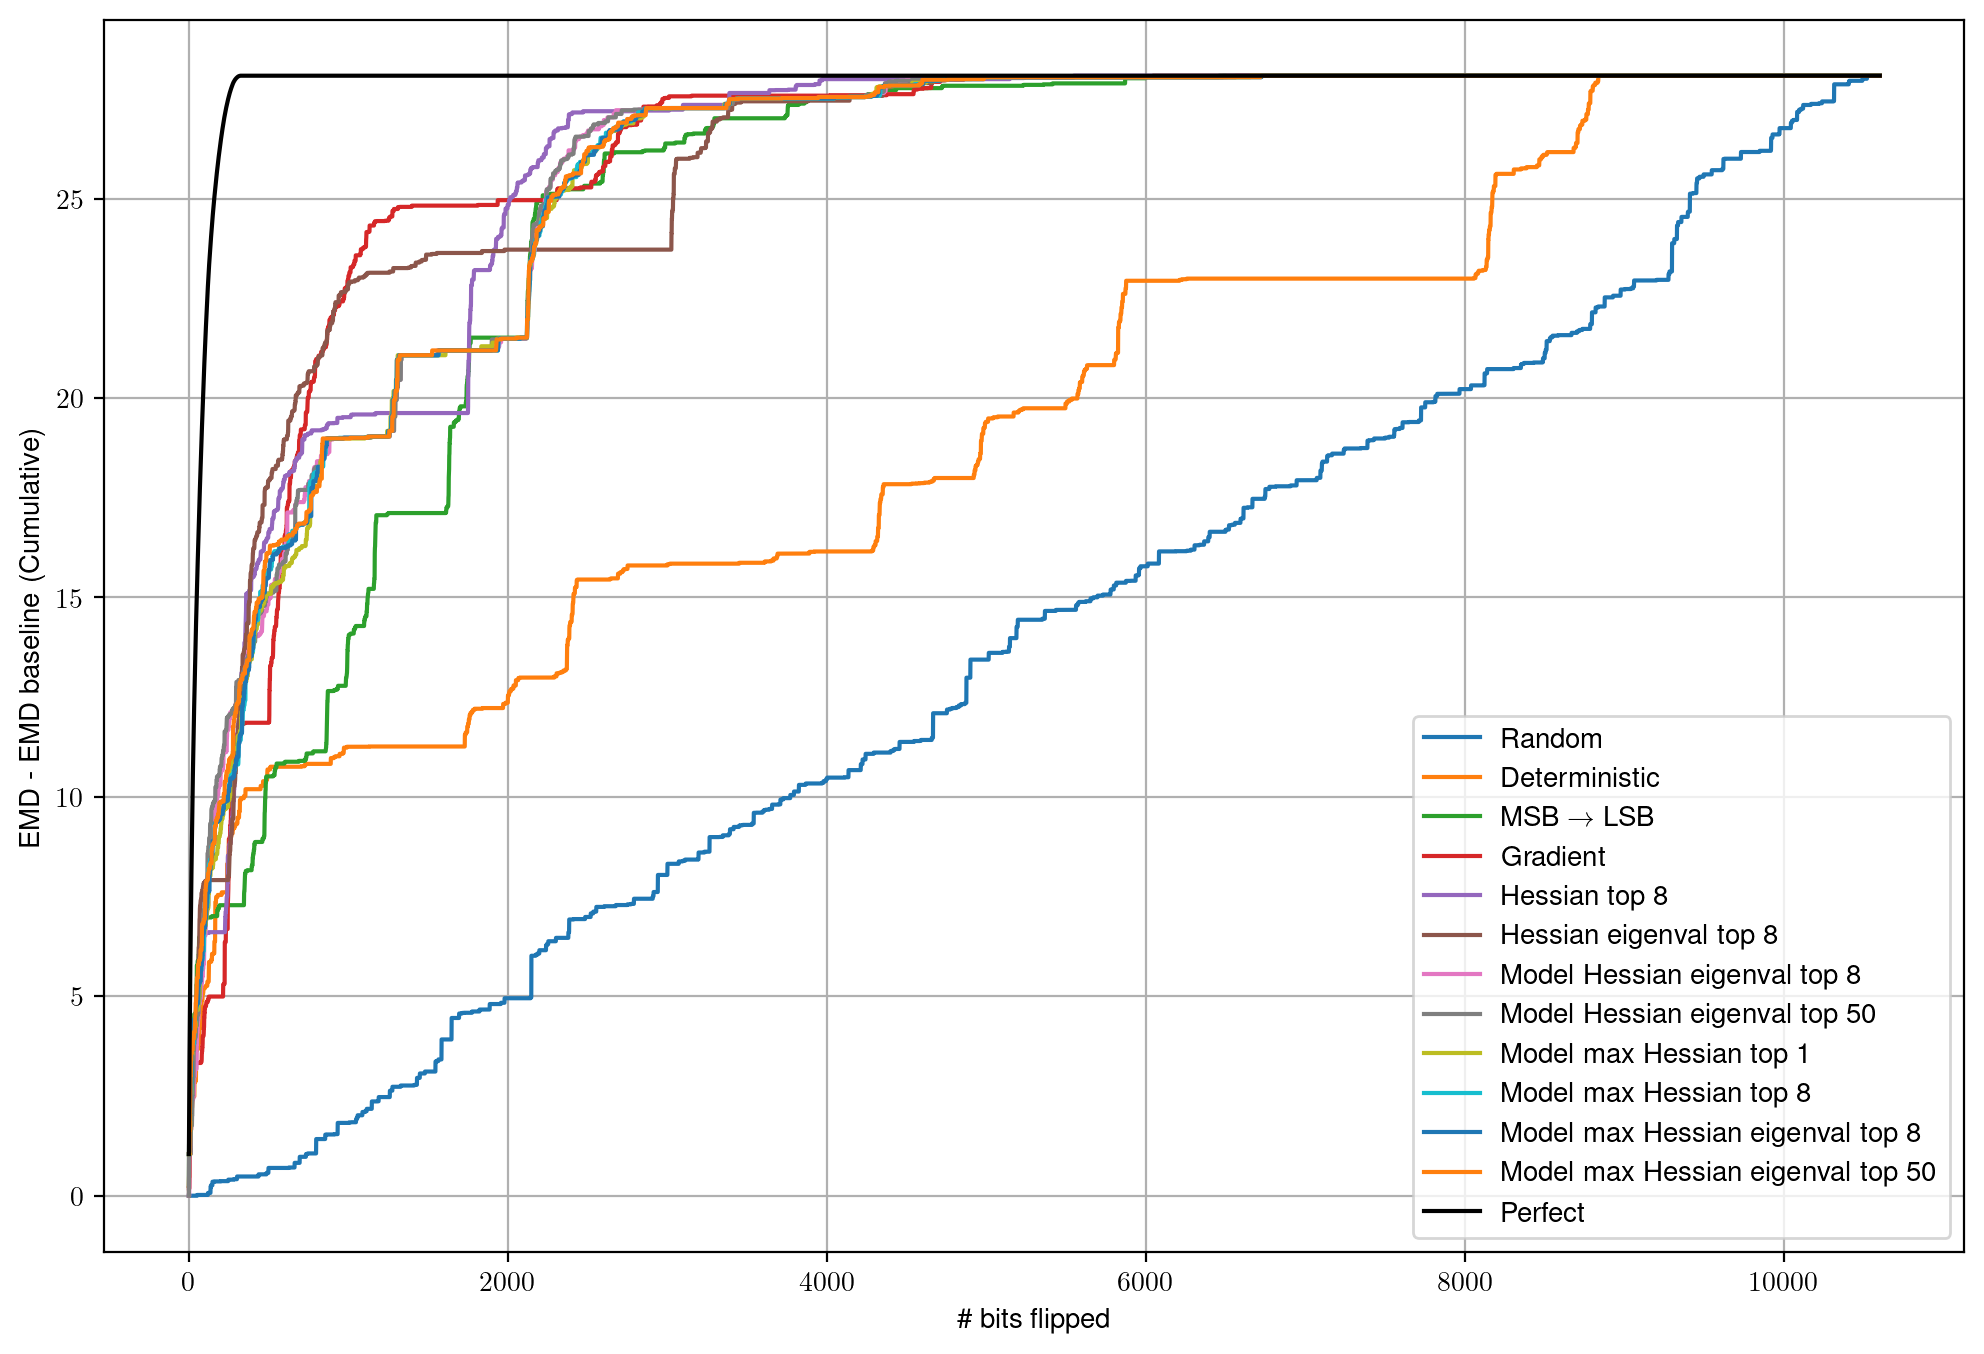

In [24]:
# Delta EMD ranking
grad_delta_emd = []
random_delta_emd = []
hessian_delta_emd = []
hessian_top3_delta_emd = []
hessian_top5_delta_emd = []
hessian_top8_delta_emd = []
hessian_eigenval_top8_delta_emd = []
model_hessian_eigenval_top1_delta_emd = []
model_hessian_eigenval_top8_delta_emd = []
model_hessian_eigenval_top24_delta_emd = []
model_hessian_eigenval_top50_delta_emd = []
model_max_hessian_top1_delta_emd = []
model_max_hessian_top8_delta_emd = []
model_max_hessian_eigenval_top5_delta_emd = []
model_max_hessian_eigenval_top8_delta_emd = []
model_max_hessian_eigenval_top50_delta_emd = []
bit_ordered_delta_emd = []
deterministic_delta_emd = []
perfect_delta_emd = []
for i in range(NUM_BITS):
    delta_emd = ground_truth_emd[i] - AVG_EMD_BASELINE_EoL
    perfect_delta_emd.append(delta_emd if delta_emd > 0 else 0)
    random_idx = ground_truth_rank.index(random_bit_indices[i])
    delta_emd = ground_truth_emd[random_idx] - AVG_EMD_BASELINE_EoL
    random_delta_emd.append(delta_emd if delta_emd > 0 else 0)
    deterministic_idx = ground_truth_rank.index(deterministic_bit_indices[i])
    delta_emd = ground_truth_emd[deterministic_idx] - AVG_EMD_BASELINE_EoL
    deterministic_delta_emd.append(delta_emd if delta_emd > 0 else 0)
    bit_ordered_idx = ground_truth_rank.index(bit_ordered_indices[i])
    delta_emd = ground_truth_emd[bit_ordered_idx] - AVG_EMD_BASELINE_EoL
    bit_ordered_delta_emd.append(delta_emd if delta_emd > 0 else 0)
    hessian_idx = ground_truth_rank.index(hessian_rank[i])
    delta_emd = ground_truth_emd[hessian_idx] - AVG_EMD_BASELINE_EoL
    hessian_delta_emd.append(delta_emd if delta_emd > 0 else 0)
    grad_idx = ground_truth_rank.index(gradient_rank[i])
    delta_emd = ground_truth_emd[grad_idx] - AVG_EMD_BASELINE_EoL
    grad_delta_emd.append(delta_emd if delta_emd > 0 else 0)
    hessian_top3_idx = ground_truth_rank.index(hessian_rank_top3[i])
    delta_emd = ground_truth_emd[hessian_top3_idx] - AVG_EMD_BASELINE_EoL
    hessian_top3_delta_emd.append(delta_emd if delta_emd > 0 else 0)
    hessian_top5_idx = ground_truth_rank.index(hessian_rank_top5[i])
    delta_emd = ground_truth_emd[hessian_top5_idx] - AVG_EMD_BASELINE_EoL
    hessian_top5_delta_emd.append(delta_emd if delta_emd > 0 else 0)
    hessian_top8_idx = ground_truth_rank.index(hessian_rank_top8[i])
    delta_emd = ground_truth_emd[hessian_top8_idx] - AVG_EMD_BASELINE_EoL
    hessian_top8_delta_emd.append(delta_emd if delta_emd > 0 else 0)
    hessian_eigenval_top8_idx = ground_truth_rank.index(hessian_eigenval_rank_top8[i])
    delta_emd = ground_truth_emd[hessian_eigenval_top8_idx] - AVG_EMD_BASELINE_EoL
    hessian_eigenval_top8_delta_emd.append(delta_emd if delta_emd > 0 else 0)
    model_hessian_eigenval_top1_idx = ground_truth_rank.index(model_hessian_eigenval_rank_top1[i])
    delta_emd = ground_truth_emd[model_hessian_eigenval_top1_idx] - AVG_EMD_BASELINE_EoL
    model_hessian_eigenval_top1_delta_emd.append(delta_emd if delta_emd > 0 else 0)
    model_hessian_eigenval_top8_idx = ground_truth_rank.index(model_hessian_eigenval_rank_top8[i])
    delta_emd = ground_truth_emd[model_hessian_eigenval_top8_idx] - AVG_EMD_BASELINE_EoL
    model_hessian_eigenval_top8_delta_emd.append(delta_emd if delta_emd > 0 else 0)
    model_hessian_eigenval_top24_idx = ground_truth_rank.index(model_hessian_eigenval_rank_top24[i])
    delta_emd = ground_truth_emd[model_hessian_eigenval_top24_idx] - AVG_EMD_BASELINE_EoL
    model_hessian_eigenval_top24_delta_emd.append(delta_emd if delta_emd > 0 else 0)
    model_hessian_eigenval_top50_idx = ground_truth_rank.index(model_hessian_eigenval_rank_top50[i])
    delta_emd = ground_truth_emd[model_hessian_eigenval_top50_idx] - AVG_EMD_BASELINE_EoL
    model_hessian_eigenval_top50_delta_emd.append(delta_emd if delta_emd > 0 else 0)
    model_max_hessian_top1_idx = ground_truth_rank.index(model_max_hessian_rank_top1[i])
    delta_emd = ground_truth_emd[model_max_hessian_top1_idx] - AVG_EMD_BASELINE_EoL
    model_max_hessian_top1_delta_emd.append(delta_emd if delta_emd > 0 else 0)
    model_max_hessian_top8_idx = ground_truth_rank.index(model_max_hessian_rank_top8[i])
    delta_emd = ground_truth_emd[model_max_hessian_top8_idx] - AVG_EMD_BASELINE_EoL
    model_max_hessian_top8_delta_emd.append(delta_emd if delta_emd > 0 else 0)
    model_max_hessian_eigenval_top5_idx = ground_truth_rank.index(model_max_hessian_eigenval_rank_top5[i])
    delta_emd = ground_truth_emd[model_max_hessian_eigenval_top5_idx] - AVG_EMD_BASELINE_EoL
    model_max_hessian_eigenval_top5_delta_emd.append(delta_emd if delta_emd > 0 else 0)
    model_max_hessian_eigenval_top8_idx = ground_truth_rank.index(model_max_hessian_eigenval_rank_top8[i])
    delta_emd = ground_truth_emd[model_max_hessian_eigenval_top8_idx] - AVG_EMD_BASELINE_EoL
    model_max_hessian_eigenval_top8_delta_emd.append(delta_emd if delta_emd > 0 else 0)
    model_max_hessian_eigenval_top50_idx = ground_truth_rank.index(model_max_hessian_eigenval_rank_top50[i])
    delta_emd = ground_truth_emd[model_max_hessian_eigenval_top50_idx] - AVG_EMD_BASELINE_EoL
    model_max_hessian_eigenval_top50_delta_emd.append(delta_emd if delta_emd > 0 else 0)

    

# Plot delta EMD
fig, ax = plt.subplots(figsize=(12,8)) # figsize in inches

print('Random:\n', random_delta_emd[:10])
print('Gradient:\n', grad_delta_emd[:10])
print('Hessian top5:\n', hessian_top5_delta_emd[:10])

random_delta_emd = np.cumsum(np.array(random_delta_emd))
deterministic_delta_emd = np.cumsum(np.array(deterministic_delta_emd))
bit_ordered_delta_emd = np.cumsum(np.array(bit_ordered_delta_emd))
hessian_delta_emd = np.cumsum(np.array(hessian_delta_emd))
grad_delta_emd = np.cumsum(np.array(grad_delta_emd))
hessian_top3_delta_emd = np.cumsum(np.array(hessian_top3_delta_emd))
hessian_top5_delta_emd = np.cumsum(np.array(hessian_top5_delta_emd))
hessian_top8_delta_emd = np.cumsum(np.array(hessian_top8_delta_emd))
hessian_eigenval_top8_delta_emd = np.cumsum(np.array(hessian_eigenval_top8_delta_emd))
model_hessian_eigenval_top1_delta_emd = np.cumsum(np.array(model_hessian_eigenval_top1_delta_emd))
model_hessian_eigenval_top8_delta_emd = np.cumsum(np.array(model_hessian_eigenval_top8_delta_emd))
model_hessian_eigenval_top24_delta_emd = np.cumsum(np.array(model_hessian_eigenval_top24_delta_emd))
model_hessian_eigenval_top50_delta_emd = np.cumsum(np.array(model_hessian_eigenval_top50_delta_emd))
perfect_delta_emd = np.cumsum(np.array(perfect_delta_emd))
model_max_hessian_top1_delta_emd = np.cumsum(np.array(model_max_hessian_top1_delta_emd))
model_max_hessian_top8_delta_emd = np.cumsum(np.array(model_max_hessian_top8_delta_emd))
model_max_hessian_eigenval_top5_delta_emd = np.cumsum(np.array(model_max_hessian_eigenval_top5_delta_emd))
model_max_hessian_eigenval_top8_delta_emd = np.cumsum(np.array(model_max_hessian_eigenval_top8_delta_emd))
model_max_hessian_eigenval_top50_delta_emd = np.cumsum(np.array(model_max_hessian_eigenval_top50_delta_emd))

# print('Random:\n', random_delta_emd[:10])
# print('Gradient:\n', grad_delta_emd[:10])
# print('Hessian top5:\n', hessian_top5_delta_emd[:10])

ax.plot(np.arange(NUM_BITS), random_delta_emd, label='Random')
ax.plot(np.arange(NUM_BITS), deterministic_delta_emd, label='Deterministic')
ax.plot(np.arange(NUM_BITS), bit_ordered_delta_emd, label=r'MSB $\rightarrow$ LSB')
# ax.plot(np.arange(NUM_BITS), hessian_delta_emd, label='Hessian')
ax.plot(np.arange(NUM_BITS), grad_delta_emd, label='Gradient')
# ax.plot(np.arange(NUM_BITS), hessian_top3_delta_emd, label='Hessian top 3')
# ax.plot(np.arange(NUM_BITS), hessian_top5_delta_emd, label='Hessian top 5')
ax.plot(np.arange(NUM_BITS), hessian_top8_delta_emd, label='Hessian top 8')
ax.plot(np.arange(NUM_BITS), hessian_eigenval_top8_delta_emd, label='Hessian eigenval top 8')
# ax.plot(np.arange(NUM_BITS), model_hessian_eigenval_top1_delta_emd, label='Model Hessian eigenval top 1')
ax.plot(np.arange(NUM_BITS), model_hessian_eigenval_top8_delta_emd, label='Model Hessian eigenval top 8')
# ax.plot(np.arange(NUM_BITS), model_hessian_eigenval_top24_delta_emd, label='Model Hessian eigenval top 24')
ax.plot(np.arange(NUM_BITS), model_hessian_eigenval_top50_delta_emd, label='Model Hessian eigenval top 50')
ax.plot(np.arange(NUM_BITS), model_max_hessian_top1_delta_emd, label='Model max Hessian top 1')
ax.plot(np.arange(NUM_BITS), model_max_hessian_top8_delta_emd, label='Model max Hessian top 8')
# ax.plot(np.arange(NUM_BITS), model_max_hessian_eigenval_top5_delta_emd, label='Model max Hessian eigenval top 5')
ax.plot(np.arange(NUM_BITS), model_max_hessian_eigenval_top8_delta_emd, label='Model max Hessian eigenval top 8')
ax.plot(np.arange(NUM_BITS), model_max_hessian_eigenval_top50_delta_emd, label='Model max Hessian eigenval top 50')
ax.plot(np.arange(NUM_BITS), perfect_delta_emd, color='black', label='Perfect')
ax.set_xlabel('\# bits flipped')
ax.set_ylabel('EMD - EMD baseline (Cumulative)')
ax.legend()
ax.grid()
# plt.xlim(0, 1000)
plt.savefig(f'plots/fault_sensitivity_ranking_delta_emd.pdf', dpi=300, bbox_inches='tight')


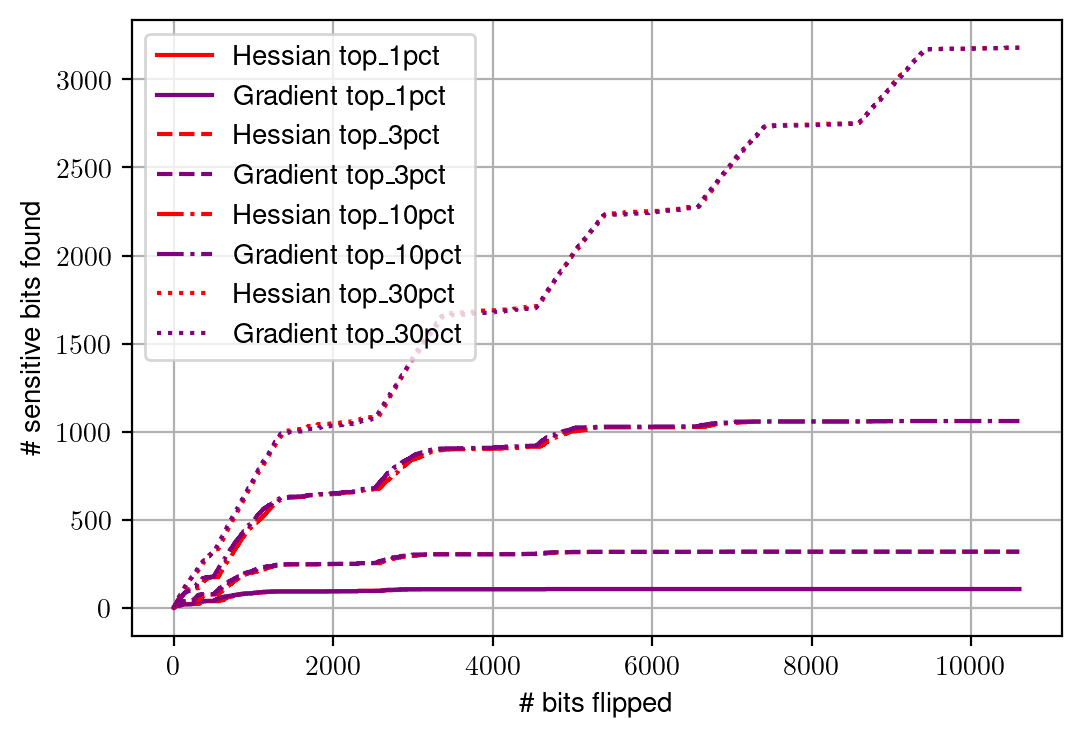

In [ ]:
# Compare 1pct, 3pct, 10pct, and 30pct searches for Hessian and gradient
top_k_bit_indices = [top_1pct_bit_indices, top_3pct_bit_indices, top_10pct_bit_indices, top_30pct_bit_indices]
top_k_labels = ['top_1pct', 'top_3pct', 'top_10pct', 'top_30pct']
linestyles = ['-', '--', '-.', ':']

fig, ax = plt.subplots(figsize=(6,4)) # Sample figsize in inches
for i in range(len(top_k_bit_indices)):
    grad_found = []
    hessian_found = []
    for j in range(NUM_BITS):
        if hessian_rank[j] in top_k_bit_indices[i]:
            hessian_found.append(1)
        if hessian_rank[j] not in top_k_bit_indices[i]:
            hessian_found.append(0)
        if gradient_rank[j] in top_k_bit_indices[i]:
            grad_found.append(1)
        if gradient_rank[j] not in top_k_bit_indices[i]:
            grad_found.append(0)
    hessian_found = np.cumsum(np.array(hessian_found))
    grad_found = np.cumsum(np.array(grad_found))
    # Plot
    ax.plot(np.arange(NUM_BITS), hessian_found, label=f'Hessian {top_k_labels[i]}', linestyle=linestyles[i], color='red')
    ax.plot(np.arange(NUM_BITS), grad_found, label=f'Gradient {top_k_labels[i]}', linestyle=linestyles[i], color='purple')
ax.set_xlabel('\# bits flipped')
ax.set_ylabel('\# sensitive bits found')
ax.legend()
ax.grid()
plt.savefig(f'plots/fault_sensitivity_ranking_hess_grad_only.pdf', dpi=300, bbox_inches='tight')
